# Modelling

Feature engineering, model training, tuning, selection and explanability.

# 0. Load Packages and Define Helper Functions

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from random import randint, uniform
from preprocessing import preprocess_df, get_amenities
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.inspection import permutation_importance
from sklearn.ensemble import StackingRegressor

import warnings
warnings.filterwarnings('ignore')

In [2]:
from sklearn.linear_model import LinearRegression, Lasso # baseline
from sklearn.ensemble import RandomForestRegressor #good
from xgboost import XGBRegressor #good
from lightgbm import LGBMRegressor # goodest

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,OneHotEncoder, RobustScaler, QuantileTransformer
from sklearn.compose import ColumnTransformer
from sklearn import set_config
set_config(display="diagram")

from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error

In [3]:
def fit_and_score(model, X_train, X_test, y_train, y_test):
    
    model.fit(X_train, y_train)
    
    # Train metrics
    pred_train= model.predict(X_train)
    train_MSE = mean_squared_error(y_train, pred_train)
    
    # Cross validated metrics
    cv_score = cross_validate(model, X_train, y_train, scoring=['r2', 'neg_mean_squared_error'],n_jobs=2, verbose=1, cv = 5) 
    
    # Test metrics
    pred_test= model.predict(X_test)
    test_MSE = mean_squared_error(y_test, pred_test)
    
    print('Train R-sq', round(model.score(X_train, y_train),4))
    print('Train MSE:', round(train_MSE,4))
    print('')
    print('CV R-sq', round(np.mean(cv_score['test_r2']),4))
    print('CV MSE:', round(-np.mean(cv_score['test_neg_mean_squared_error']),4))
    print('')
    print('Test R-sq', round(model.score(X_test, y_test),4))
    print('Test MSE:', round(test_MSE,4))
    
    return model


def random_search_pipe(model, grid, X_train, y_train):
    
    search = RandomizedSearchCV(model, grid, cv=5,n_jobs=2, scoring='r2', n_iter = 100, verbose=1)
    search.fit(X_train, y_train)
    
    print("Best params:\n{}".format(search.best_params_))
    print("Best score:\n{}".format(search.best_score_)) #Mean cross-validated score of the best_estimator
    
    return search

def grid_search_pipe(model, grid, X_train, y_train):
    
    search = GridSearchCV(model, grid, cv=5,n_jobs=2, scoring='r2', verbose=1)
    search.fit(X_train, y_train)
    
    print("Best params:\n{}".format(search.best_params_))
    print("Best score:\n{}".format(search.best_score_)) #Mean cross-validated score of the best_estimator
    
    return search

In [4]:
def check_impact(df):
    
    print('Check accuracy at this step...')
    
    random_state = 12

    dep_var = ['price_log']
    to_drop = ['id', 'host_id', 'property_type', 'price', 'host_since', 'first_review', 'last_review']

    X = df.fillna(0).drop(dep_var + to_drop, axis = 1)
    y = df['price_log'].ravel()

    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size =0.2, random_state = random_state)

    # Get numeric and categorical columns
    num_cols = list(X.select_dtypes(include=np.number).columns)
    cat_cols = list(set(X.columns)-set(X[num_cols].columns))

    # Preprocess
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), num_cols ),
            ("cat", Pipeline([('ohe', OneHotEncoder(handle_unknown='ignore'))]), cat_cols),
        ]
        , remainder='passthrough'
    )

    
    lgbm_best = Pipeline([('preprocess', preprocessor),
                    ('regressor', LGBMRegressor(random_state = random_state,
                                               boosting_type = 'gbdt',
                                               colsample_bytree = 0.5,
                                               max_bin = 10,
                                               max_depth = 12,
                                               n_estimators = 350,
                                               num_leaves = 30,
                                               subsample = 0.50))
                   ])


    model = fit_and_score(model = lgbm_best, 
                                 X_train = X_train, 
                                 X_test = X_test,
                                 y_train = y_train,
                                 y_test = y_test)
    
    print('')
    print('Shape of X: {}'.format(np.shape(X)))
    

# 1. Load and Preprocess

In [5]:
data = pd.read_csv('data/listings.csv.gz')
df = preprocess_df(data = data, verbose = True)

Columns dropped ['listing_url', 'scrape_id', 'last_scraped', 'picture_url', 'host_about', 'host_picture_url', 'calendar_last_scraped', 'license', 'host_url', 'host_thumbnail_url', 'host_verifications', 'name', 'description', 'neighborhood_overview', 'host_name', 'calendar_updated', 'bathrooms', 'host_neighbourhood', 'neighbourhood', 'host_listings_count', 'beds', 'host_location', 'host_response_time', 'host_response_rate', 'host_acceptance_rate', 'calculated_host_listings_count', 'calculated_host_listings_count_entire_homes', 'calculated_host_listings_count_private_rooms', 'calculated_host_listings_count_shared_rooms', 'minimum_minimum_nights', 'maximum_minimum_nights', 'minimum_maximum_nights', 'maximum_maximum_nights', 'neighbourhood_cleansed']
Before removing inactive listings, length = 66641
After removing inactive listings, length = 33046
After removing price = 0 listings, length = 33037
Features bathroom_num and bathroom_sharing extracted.
Int and float mv filled with 0, object m

In [6]:
df.columns

Index(['id', 'host_id', 'host_since', 'host_is_superhost',
       'host_total_listings_count', 'host_has_profile_pic',
       'host_identity_verified', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bedrooms',
       'amenities', 'price', 'minimum_nights', 'maximum_nights',
       'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'has_availability',
       'availability_30', 'availability_60', 'availability_90',
       'availability_365', 'number_of_reviews', 'number_of_reviews_ltm',
       'number_of_reviews_l30d', 'first_review', 'last_review',
       'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'instant_bookable', 'reviews_per_month',
       'bathroom_num', 'bathroom_sharing', 'price_log'],
      dtype='object')

In [7]:
df = get_amenities(data = df, 
                   num_amenities =80, # best is to call 80 amenities and select from there
                  verbose = True)

[('wifi', 32096), ('essentials', 31414), ('smoke alarm', 30603), ('heating', 29750), ('kitchen', 29321), ('hangers', 28388), ('long term stays allowed', 28070), ('iron', 27868), ('washer', 26852), ('hair dryer', 26387), ('hot water', 25305), ('shampoo', 23394), ('carbon monoxide alarm', 22656), ('dedicated workspace', 22473), ('dishes and silverware', 21126), ('cooking basics', 20499), ('refrigerator', 20424), ('bed linens', 18340), ('tv', 17925), ('microwave', 17588), ('oven', 17256), ('stove', 15436), ('dryer', 14012), ('first aid kit', 12522), ('fire extinguisher', 12352), ('coffee maker', 11651), ('dishwasher', 11275), ('private entrance', 9889), ('extra pillows and blankets', 9725), ('luggage dropoff allowed', 8066), ('host greets you', 7248), ('lockbox', 7143), ('bathtub', 7013), ('elevator', 6878), ('free parking on premises', 6310), ('shower gel', 6301), ('paid parking off premises', 5864), ('hot water kettle', 5738), ('backyard', 5698), ('free street parking', 5674), ('lock on

In [8]:
df.head()

,id,host_id,host_since,host_is_superhost,host_total_listings_count,host_has_profile_pic,host_identity_verified,neighbourhood_group_cleansed,latitude,longitude,...,amenities_outdoor dining area,amenities_children’s books and toys,amenities_cleaning before checkout,amenities_clothing storage,amenities_clothing storage: closet,amenities_mini fridge,amenities_private fenced garden or backyard,amenities_building staff,amenities_paid street parking off premises,amenities_nespresso machine
1,15400,60302,2020-03-16,0,1.0,1,1,0.0,51.48780,-0.16813,...,0,0,0,0,0,0,0,0,0,0
4,25123,103583,2020-03-15,0,3.0,1,1,0.0,51.57438,-0.21081,...,0,0,0,0,0,0,0,0,0,0
9,38610,165579,2020-08-12,1,2.0,1,1,0.0,51.50701,-0.23362,...,0,0,1,0,0,0,1,0,0,0
11,38995,167281,2020-02-21,0,1.0,1,1,0.0,51.47860,-0.06114,...,0,0,0,0,0,0,0,0,0,0
14,41311,103583,2020-01-18,0,3.0,1,1,0.0,51.57400,-0.21058,...,0,0,0,0,0,0,0,0,0,0


In [9]:
df['room_type'].value_counts()

Entire home/apt    20083
Private room       12646
Shared room          142
Hotel room           139
Name: room_type, dtype: int64

## 1.1 Baseline Before Feature Engineering

In [10]:
check_impact(df=df)

Check accuracy at this step...


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:    5.4s finished


Train R-sq 0.868
Train MSE: 0.0824

CV R-sq 0.7837
CV MSE: 0.135

Test R-sq 0.7958
Test MSE: 0.1222

Shape of X: (33010, 113)


# 2. Feature Engineering

## 2.1 Host Duration

In [11]:
# Last scraped date = 2021-12-07 (7th Dec)
df['host_duration'] = (pd.to_datetime('2021-12-10') - df['host_since']).dt.days

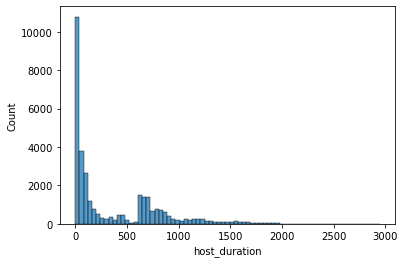

In [12]:
sns.histplot(df['host_duration'])
plt.show()

In [13]:
check_impact(df=df)

Check accuracy at this step...


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:    2.7s finished


Train R-sq 0.8714
Train MSE: 0.0803

CV R-sq 0.7859
CV MSE: 0.1337

Test R-sq 0.7966
Test MSE: 0.1217

Shape of X: (33010, 114)


## 2.2 managed_property

- Binary (0,1). 1 if properties managed by host id exceed the 95th percentile.

In [14]:
# Understand how many properties are potentially property managed

percentiles=[0.80,0.85,0.90,0.95]
percentile_rooms=[]
room_above=[]

for p in percentiles:
   percentile_rooms.append(df.host_id.value_counts().quantile(p))

print('Understand managed property percentiles beyond P75\n')
print(pd.DataFrame({'percentile':percentiles,'rooms_threshold':percentile_rooms}))

property_count=pd.DataFrame(df.groupby(['host_id'])['host_id'].count())
property_count.columns=['properties']
print('*****EXTRACT PROPERTIES MANAGED BY HOST ID *****')
property_count

Understand managed property percentiles beyond P75

   percentile  rooms_threshold
0        0.80              1.0
1        0.85              2.0
2        0.90              2.0
3        0.95              3.0
*****EXTRACT PROPERTIES MANAGED BY HOST ID *****


,properties
host_id,
4775,7
5653,1
6774,3
9323,1
10657,2
...,...
433334823,1
433435234,2
433572694,1


In [15]:
property_count['prop_managed']=property_count['properties'].map(lambda x: 1 if x>=percentile_rooms[3] else 0)
df=pd.merge(df,property_count,on='host_id',how='inner')
df.prop_managed.value_counts()

0    22496
1    10514
Name: prop_managed, dtype: int64

In [16]:
check_impact(df=df)

Check accuracy at this step...


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:    2.6s finished


Train R-sq 0.8744
Train MSE: 0.0775

CV R-sq 0.7872
CV MSE: 0.1313

Test R-sq 0.7891
Test MSE: 0.1324

Shape of X: (33010, 116)


## 2.3 Occupancy Rate

- short term proxy: avail30
- mid term proxy: avail60-90
- long term proxy: avail365

In [17]:
cols=['availability_30','availability_60', 'availability_90','availability_365']
df[cols].describe()

,availability_30,availability_60,availability_90,availability_365
count,33010.000000,33010.000000,33010.000000,33010.000000
mean,6.882187,18.561527,31.615177,121.371191
std,9.251464,20.881292,33.341793,134.103803
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,1.000000,7.000000,17.000000,66.000000
75%,12.000000,37.000000,65.000000,248.000000
max,30.000000,60.000000,90.000000,365.000000


In [18]:
df['occ_30D']=1-round(df.availability_30/30,2)
df['occ_6090D']=((1-round(df.availability_60/60,2))+(1-round(df.availability_90/90,2)))/2
df['occ_365']=1-round(df.availability_365/365,2)

df=df.drop(cols,axis=1) # do not drop

In [19]:
df.columns

Index(['id', 'host_id', 'host_since', 'host_is_superhost',
       'host_total_listings_count', 'host_has_profile_pic',
       'host_identity_verified', 'neighbourhood_group_cleansed', 'latitude',
       'longitude',
       ...
       'amenities_private fenced garden or backyard',
       'amenities_building staff',
       'amenities_paid street parking off premises',
       'amenities_nespresso machine', 'host_duration', 'properties',
       'prop_managed', 'occ_30D', 'occ_6090D', 'occ_365'],
      dtype='object', length=123)

In [20]:
check_impact(df=df)

Check accuracy at this step...


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:    2.9s finished


Train R-sq 0.8703
Train MSE: 0.08

CV R-sq 0.7849
CV MSE: 0.1328

Test R-sq 0.7871
Test MSE: 0.1336

Shape of X: (33010, 115)


## 2.4 Location Variables

In [21]:
# Load computed location features
location_features = ['station', 'station_dist','walking_distance']
df = df.merge(pd.read_csv('computed_features/london_nearest_tube.csv')[['id']+location_features],left_on='id', right_on='id',how='left')
df.head()

,id,host_id,host_since,host_is_superhost,host_total_listings_count,host_has_profile_pic,host_identity_verified,neighbourhood_group_cleansed,latitude,longitude,...,amenities_nespresso machine,host_duration,properties,prop_managed,occ_30D,occ_6090D,occ_365,station,station_dist,walking_distance
0,15400,60302,2020-03-16,0,1.0,1,1,0.0,51.48780,-0.16813,...,0,634,1,0,1.0,1.000,0.99,South Kensington,805.406363,0.0
1,25123,103583,2020-03-15,0,3.0,1,1,0.0,51.57438,-0.21081,...,0,635,3,1,1.0,1.000,1.00,Brent Cross,302.665825,1.0
2,41311,103583,2020-01-18,0,3.0,1,1,0.0,51.57400,-0.21058,...,0,692,3,1,0.9,0.960,0.99,Brent Cross,346.564965,1.0
3,19516454,103583,2020-03-20,0,3.0,1,1,0.0,51.57466,-0.20916,...,0,630,3,1,1.0,1.000,1.00,Brent Cross,361.025714,1.0
4,38610,165579,2020-08-12,1,2.0,1,1,0.0,51.50701,-0.23362,...,0,485,1,0,0.8,0.335,0.07,Shepherds Bush Market,449.743591,3.0


## 2.5 Sentiment

In [22]:
############## Add sentiment features #################
# df_sentiment = pd.read_csv('computed_features/sentiment_score.csv')
# df_sentiment=df_sentiment.drop(columns=['Unnamed: 0'])
# df=pd.merge(df,df_sentiment,left_on='id', right_on='listing_id',how='left')
# df = df.drop(['listing_id'], axis = 1)
# df.head()

# 3. Models

In [23]:
# Format columns
import re
df = df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

In [24]:
df.columns.tolist()

['id',
 'host_id',
 'host_since',
 'host_is_superhost',
 'host_total_listings_count',
 'host_has_profile_pic',
 'host_identity_verified',
 'neighbourhood_group_cleansed',
 'latitude',
 'longitude',
 'property_type',
 'room_type',
 'accommodates',
 'bedrooms',
 'price',
 'minimum_nights',
 'maximum_nights',
 'minimum_nights_avg_ntm',
 'maximum_nights_avg_ntm',
 'has_availability',
 'number_of_reviews',
 'number_of_reviews_ltm',
 'number_of_reviews_l30d',
 'first_review',
 'last_review',
 'review_scores_rating',
 'review_scores_accuracy',
 'review_scores_cleanliness',
 'review_scores_checkin',
 'review_scores_communication',
 'review_scores_location',
 'review_scores_value',
 'instant_bookable',
 'reviews_per_month',
 'bathroom_num',
 'bathroom_sharing',
 'price_log',
 'amenities_wifi',
 'amenities_essentials',
 'amenities_smokealarm',
 'amenities_heating',
 'amenities_kitchen',
 'amenities_hangers',
 'amenities_longtermstaysallowed',
 'amenities_iron',
 'amenities_washer',
 'amenities_h

In [25]:
features_selected = ['host_total_listings_count',
                         'neighbourhood_group_cleansed',
                         'latitude',
                         'longitude',
                         'room_type',
                         'accommodates',
                         'bedrooms',
                         'minimum_nights',
                         'maximum_nights',
                         'minimum_nights_avg_ntm',
                         'maximum_nights_avg_ntm',
                         'number_of_reviews',
                         'number_of_reviews_ltm',
                         'number_of_reviews_l30d',
                         'review_scores_rating',
                         'review_scores_accuracy',
                         'review_scores_cleanliness',
                         'review_scores_checkin',
                         'review_scores_communication',
                         'review_scores_location',
                         'review_scores_value',
                         'reviews_per_month',
                         'bathroom_num',
                         'bathroom_sharing',
                        'amenities_wifi',
                        'amenities_essentials',
                        'amenities_smokealarm',
                        'amenities_heating',
                        'amenities_kitchen',
                        'amenities_hangers',
                        'amenities_longtermstaysallowed',
                        'amenities_iron',
                        'amenities_washer',
                        'amenities_hairdryer',
                        'amenities_hotwater',
                        'amenities_shampoo',
                        'amenities_carbonmonoxidealarm',
                        'amenities_dedicatedworkspace',
                        'amenities_dishesandsilverware',
                        'amenities_cookingbasics',
                        'amenities_refrigerator',
                        'amenities_bedlinens',
                        'amenities_tv',
                        'amenities_microwave',
                        'amenities_oven',
                        'amenities_stove',
                        'amenities_dryer',
                        'amenities_firstaidkit',
                        'amenities_fireextinguisher',
                        'amenities_coffeemaker',
                        'amenities_dishwasher',
                        'amenities_privateentrance',
                        'amenities_extrapillowsandblankets',
                        'amenities_luggagedropoffallowed',
                        'amenities_hostgreetsyou',
                        'amenities_lockbox',
                        'amenities_bathtub',
                        'amenities_elevator',
                        'amenities_freeparkingonpremises',
                        'amenities_showergel',
                        'amenities_paidparkingoffpremises',
                        'amenities_hotwaterkettle',
                        'amenities_backyard',
                        'amenities_freestreetparking',
                        'amenities_lockonbedroomdoor',
                        'amenities_cabletv',
                        'amenities_patioorbalcony',
                        'amenities_freezer',
                        'amenities_tvwithstandardcable',
                        'amenities_cleaningproducts',
                        'amenities_toaster',
                        'amenities_diningtable',
                        'amenities_wineglasses',
                        'amenities_roomdarkeningshades',
                        'amenities_bodysoap',
                        'amenities_breakfast',
                        'amenities_dryingrackforclothing',
                        'amenities_singlelevelhome',
                        'amenities_securitycamerasonproperty',
                        'amenities_conditioner',
                        'amenities_indoorfireplace',
                        'amenities_portablefans',
                        'amenities_ethernetconnection',
                        'amenities_outdoorfurniture',
                        'amenities_laundromatnearby',
                        'amenities_packnplaytravelcrib',
                        'amenities_crib',
                        'amenities_airconditioning',
                        'amenities_highchair',
                        'amenities_bakingsheet',
                        'amenities_bbqgrill',
                        'amenities_paidparkingonpremises',
                        'amenities_privatepatioorbalcony',
                        'amenities_centralheating',
                        'amenities_outdoordiningarea',
                        'amenities_childrensbooksandtoys',
                        'amenities_cleaningbeforecheckout',
                        'amenities_clothingstorage',
                        'amenities_clothingstoragecloset',
                        'amenities_minifridge',
                        'amenities_privatefencedgardenorbackyard',
                        'amenities_buildingstaff',
                        'amenities_paidstreetparkingoffpremises',
                        'amenities_nespressomachine',
                         'host_duration',
                         'properties',
                         'occ_30D',
                         'occ_6090D',
                         'occ_365'] + location_features

In [26]:
random_state = 12

dep_var = ['price_log']
#to_drop = ['id', 'host_id', 'property_type', 'price', 'host_since', 'first_review', 'last_review']

X = df[features_selected]
y = df['price_log'].ravel()

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size =0.2, random_state = random_state)

# Get numeric and categorical columns
num_cols = list(X.select_dtypes(include=np.number).columns)
cat_cols = list(set(X.columns)-set(X[num_cols].columns))

print('X shape: {}'.format(np.shape(X)))
print('y shape: {}'.format(np.shape(y)))
print(cat_cols)

X shape: (33010, 112)
y shape: (33010,)
['room_type', 'station', 'bathroom_sharing']


In [27]:
# Preprocess
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols ),
        ("cat", Pipeline([('ohe', OneHotEncoder(handle_unknown='ignore'))]), cat_cols),
    ]
    , remainder='passthrough'
)

preprocessor

ColumnTransformer(remainder='passthrough',
                  transformers=[('num', StandardScaler(),
                                 ['host_total_listings_count',
                                  'neighbourhood_group_cleansed', 'latitude',
                                  'longitude', 'accommodates', 'bedrooms',
                                  'minimum_nights', 'maximum_nights',
                                  'minimum_nights_avg_ntm',
                                  'maximum_nights_avg_ntm', 'number_of_reviews',
                                  'number_of_reviews_ltm',
                                  'number_of_reviews_l30d',
                                  'review_...
                                  'review_scores_value', 'reviews_per_month',
                                  'bathroom_num', 'amenities_wifi',
                                  'amenities_essentials',
                                  'amenities_smokealarm', 'amenities_heating',
                                  'amenities_kitchen', 'amenities_hangers',
                                  'amenities_longtermstaysallowed',
                                  'amenities_iron', ...]),
                                ('cat',
                                 Pipeline(steps=[('ohe',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['room_type', 'station', 'bathroom_sharing'])])

## Linear Regression (Baseline)

In [38]:
# Pipeline for One-Hot Encoding

linreg_pipe = Pipeline([('preprocess', preprocessor),
                    ('regressor', LinearRegression())
                   ])

linreg_model = fit_and_score(model = linreg_pipe, 
                             X_train = X_train, 
                             X_test = X_test,
                             y_train = y_train,
                             y_test = y_test)

Train R-sq 0.7345
Train MSE: 0.1638

CV R-sq 0.716
CV MSE: 0.1753

Test R-sq 0.7048
Test MSE: 0.1852


## XGB Regressor

### Baseline XGB

In [39]:
xgb_pipe = Pipeline([('preprocess', preprocessor),
                    ('regressor', XGBRegressor(random_state = random_state,
                                              use_label_encoder=False)) # same as linear regression
                   ])

xgb_model = fit_and_score(model = xgb_pipe, 
                         X_train = X_train, 
                         X_test = X_test,
                         y_train = y_train,
                         y_test = y_test)

Train R-sq 0.886
Train MSE: 0.0703

CV R-sq 0.7798
CV MSE: 0.1359

Test R-sq 0.7787
Test MSE: 0.1389


### Tuning XGB

RandomizedSearch then GridSearch

In [ ]:
random_grid = {
    'preprocess__num':[StandardScaler(), RobustScaler(), QuantileTransformer()], # two different pipelines
    "regressor__n_estimators": range(50, 500, 50),
    "regressor__max_depth": range(2,20,2),
    'regressor__subsample': np.linspace(0.3, 1, 10),
    'regressor__colsample_bytree': np.linspace(0.2, 1, 5),
    'regressor__reg_lambda': np.linspace(0, 5, 11),
    'regressor__reg_alpha': np.linspace(0, 5, 11),
    'regressor__gamma': np.linspace(0, 5, 5)
}

rsearch_xgb = random_search_pipe(xgb_pipe, random_grid, X_train, y_train)

[08:08:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:08:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:08:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:08:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:08:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:08:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:08:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:08:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

In [ ]:
grid = {
    'preprocess__num':[RobustScaler()], # two different pipelines
    "regressor__n_estimators": [350,400,450],
    "regressor__max_depth": [6,8,10],
    'regressor__subsample': [0.9],
    'regressor__colsample_bytree': [0.6],
    'regressor__reg_lambda': [1,2,3],
    'regressor__reg_alpha': [2,3.5,4.5],
    'regressor__gamma': [2,3.75]
}

gsearch_xgb = grid_search_pipe(xgb_pipe, grid, X_train, y_train)

[09:02:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:02:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:03:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:03:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:03:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:03:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:03:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:03:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

### XGB Best

Define 'xgb_best' model for use in stacking regressor

In [ ]:
# Preprocess
preprocessor_xgb = ColumnTransformer(transformers=[('num', RobustScaler(), num_cols ),
                                                   ("cat", Pipeline([('ohe', OneHotEncoder(handle_unknown='ignore'))]), cat_cols),
                                                  ], remainder='passthrough')

xgb_best = Pipeline([('preprocess', preprocessor_xgb),
                    ('regressor', XGBRegressor(random_state = random_state,
                                                use_label_encoder=False,
                                                subsample = 0.9,
                                                #reg_lambda = 3,
                                                reg_alpha = 2,
                                                n_estimators = 300, # original was 500
                                                max_depth = 6, #original was 6
                                                gamma = 2,
                                                colsample_bytree = 0.6
                                                ))
                                            ])

xgb_model = fit_and_score(model = xgb_best, 
                         X_train = X_train, 
                         X_test = X_test,
                         y_train = y_train,
                         y_test = y_test)

Train R-sq 0.867
Train MSE: 0.0874

CV R-sq 0.8209
CV MSE: 0.1178

Test R-sq 0.839
Test MSE: 0.1094


## LGBM Regressor

### Baseline LGBM

In [32]:
lgb_pipe = Pipeline([('preprocess', preprocessor),
                    ('regressor', LGBMRegressor(random_state = random_state))
                   ])

lgb_model = fit_and_score(model = lgb_pipe, 
                         X_train = X_train, 
                         X_test = X_test,
                         y_train = y_train,
                         y_test = y_test)

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:    2.1s finished


Train R-sq 0.8323
Train MSE: 0.1035

CV R-sq 0.7811
CV MSE: 0.1351

Test R-sq 0.7821
Test MSE: 0.1368


### Tuning LGBM

In [ ]:
# Best params:
# {'regressor__subsample': 0.5333333333333333, 'regressor__num_leaves': 30, 'regressor__n_estimators': 300, 'regressor__max_depth': 14, 'regressor__max_bin': 10, 'regressor__colsample_bytree': 0.4, 'regressor__boosting_type': 'gbdt', 'preprocess__num': StandardScaler()}
# Best score:
# 0.8378305514357471
random_grid = {'preprocess__num':[StandardScaler(),RobustScaler(), QuantileTransformer()],
                'regressor__boosting_type': ['gbdt','dart','goss'],
                'regressor__n_estimators': range(50, 500, 50),
                'regressor__max_bin':range(2, 20, 2),
                'regressor__num_leaves':range(10, 200, 10),
                'regressor__max_depth': np.arange(2,20,2).tolist(),
                'regressor__colsample_bytree' : np.linspace(0.2, 1, 5),
                'regressor__subsample' : np.linspace(0.3, 1, 10)}

rsearch_lgb = random_search_pipe(lgb_pipe, random_grid, X_train, y_train)

Best params:
{'regressor__subsample': 0.5333333333333333, 'regressor__num_leaves': 30, 'regressor__n_estimators': 300, 'regressor__max_depth': 14, 'regressor__max_bin': 10, 'regressor__colsample_bytree': 0.4, 'regressor__boosting_type': 'gbdt', 'preprocess__num': StandardScaler()}
Best score:
0.8378305514357471


In [ ]:
# Best params:
# {'preprocess__num': StandardScaler(), 'regressor__boosting_type': 'gbdt', 'regressor__colsample_bytree': 0.3, 'regressor__max_bin': 10, 'regressor__max_depth': 12, 'regressor__n_estimators': 350, 'regressor__num_leaves': 30, 'regressor__subsample': 0.5}
# Best score:
# 0.8401114152763149
grid= {'preprocess__num':[StandardScaler()],
         'regressor__boosting_type': ['gbdt'],
         'regressor__n_estimators': [250,300,350],
         'regressor__max_bin':[10],
         'regressor__num_leaves': [25,30,35],
         'regressor__max_depth': [12,14,16],
         'regressor__colsample_bytree' : [0.3,0.4,0.5],
         'regressor__subsample' : [0.50,0.55,0.60]}

gsearch_lgb = grid_search_pipe(lgb_pipe, grid, X_train, y_train)

Best params:
{'preprocess__num': StandardScaler(), 'regressor__boosting_type': 'gbdt', 'regressor__colsample_bytree': 0.3, 'regressor__max_bin': 10, 'regressor__max_depth': 12, 'regressor__n_estimators': 350, 'regressor__num_leaves': 30, 'regressor__subsample': 0.5}
Best score:
0.8401114152763149


### Best LGBM

In [ ]:
# # Preprocess
# preprocessor_lgbm = ColumnTransformer(
#     transformers=[
#         ('num', QuantileTransformer(), num_cols),
#         ("cat", Pipeline([('ohe', OneHotEncoder(handle_unknown='ignore'))]), cat_cols),
#     ]
#     , remainder='passthrough'
# )

lgbm_best = Pipeline([('preprocess', preprocessor),
                    ('regressor', LGBMRegressor(random_state = random_state,
                                               boosting_type = 'gbdt',
                                               colsample_bytree = 0.5,
                                               max_bin = 10,
                                               max_depth = 12,
                                               n_estimators = 350,
                                               num_leaves = 30,
                                               subsample = 0.50))
                   ])
        
lgb_model_tuned = fit_and_score(model = lgbm_best, 
                         X_train = X_train, 
                         X_test = X_test,
                         y_train = y_train,
                         y_test = y_test)

Train R-sq 0.9301
Train MSE: 0.046

CV R-sq 0.8392
CV MSE: 0.1058

Test R-sq 0.855
Test MSE: 0.0985


## Random Forest Regressor

### Baseline RFR

In [43]:
rf_pipe= Pipeline([('preprocess', preprocessor),
                    ('regressor', RandomForestRegressor(random_state = random_state)) 
                   ])

rf_model = fit_and_score(model = rf_pipe, 
                         X_train = X_train, 
                         X_test = X_test,
                         y_train = y_train,
                         y_test = y_test)

KeyboardInterrupt: 

### Tuning RFR

In [ ]:
# Best params:
# {'regressor__oob_score': False, 'regressor__n_estimators': 300, 'regressor__min_samples_split': 3, 'regressor__max_features': 'log2', 'regressor__max_depth': 18, 'regressor__ccp_alpha': 0.01, 'regressor__bootstrap': True, 'preprocess__num': RobustScaler()}
# Best score:
# 0.6374678957100857
random_grid = {'preprocess__num':[StandardScaler(),RobustScaler(), QuantileTransformer()],
               'regressor__max_features':['auto','sqrt','log2'],
                'regressor__n_estimators': range(100,500,50),
                'regressor__bootstrap': [True,False],
                'regressor__oob_score':[True,False],
                'regressor__max_depth': range(2, 20, 2),
                'regressor__ccp_alpha' : np.arange(0.01, 0.30,0.02).tolist(),
              'regressor__min_samples_split' : range(1,5,1)}

rsearch_rf = random_search_pipe(rf_pipe, random_grid, X_train, y_train)

Best params:
{'regressor__oob_score': False, 'regressor__n_estimators': 300, 'regressor__min_samples_split': 3, 'regressor__max_features': 'log2', 'regressor__max_depth': 18, 'regressor__ccp_alpha': 0.01, 'regressor__bootstrap': True, 'preprocess__num': RobustScaler()}
Best score:
0.6374678957100857


In [ ]:
# Best params:
# {'preprocess__num': RobustScaler(), 'regressor__bootstrap': True, 'regressor__ccp_alpha': 0.0, 'regressor__max_depth': 22, 'regressor__max_features': 'log2', 'regressor__min_samples_split': 2, 'regressor__n_estimators': 350, 'regressor__oob_score': False}
# Best score:
# 0.8072706815508367

grid = {'preprocess__num':[RobustScaler()],
        'regressor__max_features':['log2'],
        'regressor__n_estimators': [200, 250, 300, 350],
        'regressor__bootstrap': [True],
        'regressor__oob_score':[False],
        'regressor__max_depth': [14, 18, 22],
        'regressor__ccp_alpha' : [0.0, 0.01, 0.05],
        'regressor__min_samples_split' : [2, 3, 4]}

gsearch_rf = grid_search_pipe(rf_pipe, grid, X_train, y_train)

Best params:
{'preprocess__num': RobustScaler(), 'regressor__bootstrap': True, 'regressor__ccp_alpha': 0.0, 'regressor__max_depth': 22, 'regressor__max_features': 'log2', 'regressor__min_samples_split': 2, 'regressor__n_estimators': 350, 'regressor__oob_score': False}
Best score:
0.8072706815508367


### Best RFR

In [ ]:
preprocessor_rf = ColumnTransformer(
    transformers=[
        ('num', QuantileTransformer(), num_cols),
        ("cat", Pipeline([('ohe', OneHotEncoder(handle_unknown='ignore'))]), cat_cols),
    ]
    , remainder='passthrough'
)

rf_best = Pipeline([('preprocess', preprocessor_rf), # try with robust scaler
                    ('regressor', RandomForestRegressor(random_state = random_state,
                                                        max_features = 'sqrt',
                                                       n_estimators = 450,
                                                       bootstrap = False,
                                                       oob_score = False,
                                                       max_depth = 22,
                                                       ccp_alpha = 0.0,
                                                       min_samples_split = 2
                                                       )) 
                   ])

rf_model_tuned = fit_and_score(model = rf_best, 
                         X_train = X_train, 
                         X_test = X_test,
                         y_train = y_train,
                         y_test = y_test)

Train R-sq 0.9994
Train MSE: 0.0004

CV R-sq 0.8186
CV MSE: 0.1193

Test R-sq 0.8371
Test MSE: 0.1107


## Stacking Regressor

Stack best regressors and tune Level 1

In [ ]:
# Set up estimators (pipelines with best params for each regressor)
estimators = [
    ("LGBM Classifier", lgbm_best),
    ("XGBoost Classifier", xgb_best),
    ("Random Forest Classifier", rf_best)
]

stacking_regressor = StackingRegressor(estimators=estimators, 
                                         final_estimator=LGBMRegressor(random_state=random_state))
stacking_regressor

StackingRegressor(estimators=[('LGBM Classifier',
                               Pipeline(steps=[('preprocess',
                                                ColumnTransformer(remainder='passthrough',
                                                                  transformers=[('num',
                                                                                 StandardScaler(),
                                                                                 ['host_total_listings_count',
                                                                                  'latitude',
                                                                                  'longitude',
                                                                                  'accommodates',
                                                                                  'bedrooms',
                                                                                  'minimum_nights',
                                                                                  'maximum_nights',
                                                                                  'minimum_nights_avg_ntm',
                                                                                  'maximum_nights_avg_ntm',
                                                                                  'number_of_reviews',
                                                                                  'number_of...
                                                                                  'amenities_airconditioning',
                                                                                  'amenities_dishesandsilverware', ...]),
                                                                                ('cat',
                                                                                 Pipeline(steps=[('ohe',
                                                                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                                                                 ['bathroom_sharing',
                                                                                  'room_type',
                                                                                  'neighbourhood_group_cleansed'])])),
                                               ('regressor',
                                                RandomForestRegressor(bootstrap=False,
                                                                      max_depth=22,
                                                                      max_features='sqrt',
                                                                      n_estimators=450,
                                                                      random_state=12))]))],
                  final_estimator=LGBMRegressor(random_state=12))

In [ ]:
stacking_regressor_base = fit_and_score(model = stacking_regressor, 
                         X_train = X_train, 
                         X_test = X_test,
                         y_train = y_train,
                         y_test = y_test)

Train R-sq 0.9482
Train MSE: 0.0341

CV R-sq 0.8377
CV MSE: 0.1067

Test R-sq 0.8565
Test MSE: 0.0975


### Stacking L1 Tuning

GridSearch only

In [ ]:
# Tune LightGBM at Level 1
grid = {'final_estimator__n_estimators': [50, 100, 150, 200, 250],
               'final_estimator__max_depth': [2, 4, 6, 8, 10]}

search = grid_search_pipe(model = stacking_regressor, 
                            grid = grid, 
                            X_train = X_train, 
                            y_train = y_train) 

Best params:
{'final_estimator__max_depth': 4, 'final_estimator__n_estimators': 50}
Best score:
0.8355395663578541


### Best Stacker

In [ ]:
# Set up estimators (pipelines with best params for each regressor)
estimators = [
    ("LGBM Classifier", lgbm_best),
    ("XGBoost Classifier", xgb_best),
    ("Random Forest Classifier", rf_best)
]

stacking_regressor_best = StackingRegressor(estimators=estimators, 
                                         final_estimator=LGBMRegressor(random_state=random_state,
                                                                      max_depth = 4,
                                                                      n_estimators = 50))
stacking_regressor_best

StackingRegressor(estimators=[('LGBM Classifier',
                               Pipeline(steps=[('preprocess',
                                                ColumnTransformer(remainder='passthrough',
                                                                  transformers=[('num',
                                                                                 StandardScaler(),
                                                                                 ['host_total_listings_count',
                                                                                  'latitude',
                                                                                  'longitude',
                                                                                  'accommodates',
                                                                                  'bedrooms',
                                                                                  'minimum_nights',
                                                                                  'maximum_nights',
                                                                                  'minimum_nights_avg_ntm',
                                                                                  'maximum_nights_avg_ntm',
                                                                                  'number_of_reviews',
                                                                                  'number_of...
                                                                                  'amenities_dishesandsilverware', ...]),
                                                                                ('cat',
                                                                                 Pipeline(steps=[('ohe',
                                                                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                                                                 ['neighbourhood_group_cleansed',
                                                                                  'bathroom_sharing',
                                                                                  'room_type'])])),
                                               ('regressor',
                                                RandomForestRegressor(bootstrap=False,
                                                                      max_depth=22,
                                                                      max_features='sqrt',
                                                                      n_estimators=450,
                                                                      random_state=12))]))],
                  final_estimator=LGBMRegressor(max_depth=4, n_estimators=50,
                                                random_state=12))

In [ ]:
stacking_regressor_best = fit_and_score(model = stacking_regressor_best, 
                         X_train = X_train, 
                         X_test = X_test,
                         y_train = y_train,
                         y_test = y_test)

Train R-sq 0.9527
Train MSE: 0.0311

CV R-sq 0.8407
CV MSE: 0.1048

Test R-sq 0.8577
Test MSE: 0.0967


# 4. Explainability and Feature Importance


### 4.1 Permutation Feature Importance

Use pre-computed feature_importances.csv to adjust graphs.

In [33]:
def plot_feature_importance(name, model_pipeline):
    # Inspect Feature Permutation Importances
    result = permutation_importance(model_pipeline, X_test, y_test, n_repeats=50, random_state=42)

    feature_names = [f"{i}" for i in X.columns]
    importances = result.importances_mean
    std = result.importances_std

    my_dict = {'feature_names': feature_names, 'feature_impt': importances, 'std': std}

    pi = pd.DataFrame.from_dict(my_dict)
    pi.sort_values(by = 'feature_impt', ascending = False, inplace = True)
    
    return pi

# to plot the feature importance for the best model 
pi = plot_feature_importance(name = 'Stacking Regressor', model_pipeline = stacking_regressor_best)
pi.to_csv('output/feature_importances.csv')

In [34]:
# Load pre-computed feature_importances from best stacker
pi = pd.read_csv('output/feature_importances.csv')

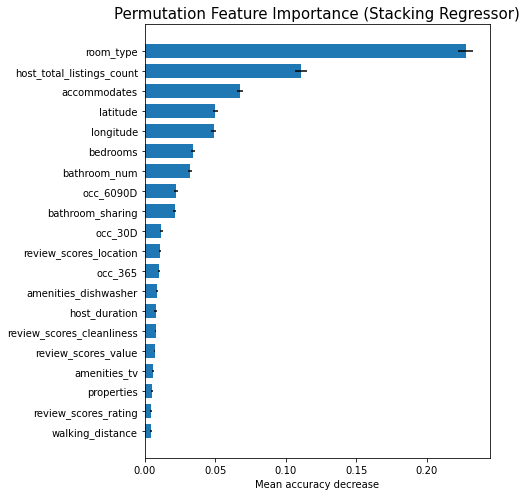

In [35]:
# Visualize feature importances
pi_top20 = pi[0:20]
name = 'Stacking Regressor'
fig, ax = plt.subplots(figsize=[7,7])
plt.barh(y = pi_top20['feature_names'], width = pi_top20['feature_impt'], xerr=pi_top20['std'], height = 0.7)
ax.set_title("Permutation Feature Importance ({})".format(name), fontsize = 15)
ax.set_xlabel("Mean accuracy decrease")
ax.invert_yaxis()  # labels read top-to-bottom
fig.tight_layout()
plt.show()

### 4.2 SHAP Values

In [36]:
import shap

In [38]:
explainer = shap.TreeExplainer(lgbm_best.named_steps["regressor"])
shap_values = explainer.shap_values(lgbm_best[:-1].transform(X_train))
np.shape(shap_values)

(26408, 719)

In [51]:
all_features = list(num_cols)+list(lgbm_best.named_steps['preprocess'].named_transformers_['cat'].get_feature_names_out(cat_cols))
X_train_preprocessed = preprocessor.transform(X_train)
X_train_preprocessed = pd.DataFrame(X_train_preprocessed, columns = all_features)
print(np.shape(X_train_preprocessed))

AttributeError: 'Pipeline' object has no attribute 'get_feature_names_out'

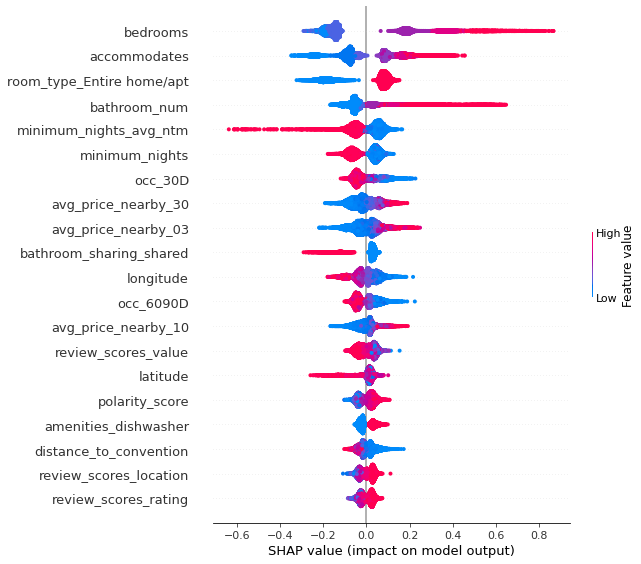

In [ ]:
plt.figure(figsize = (8,5))
shap.summary_plot(shap_values, X_train_preprocessed)
plt.show()

### 4.3 Actual vs Predicted

In [ ]:
import matplotlib.cm as cm
sns.set_style("whitegrid")

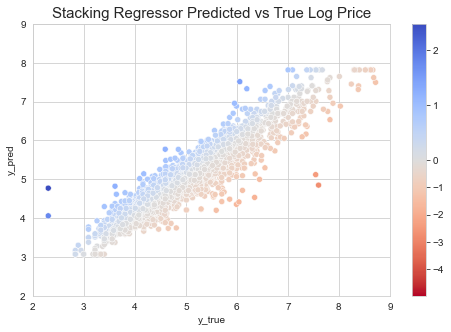

In [ ]:
stacking_regressor_best.fit(X_train, y_train)
pred = stacking_regressor_best.predict(X_test)
df_pred = pd.DataFrame.from_dict({'y_pred': pred, 'y_true': y_test})
df_pred['deviation'] = df_pred['y_pred'] - df_pred['y_true']

# Get/set params for the colour mapping
vcenter = 0
vmin, vmax = df_pred['deviation'].min(), df_pred['deviation'].max()
normalize = mcolors.TwoSlopeNorm(vcenter=vcenter, vmin=vmin, vmax=vmax)
colormap = cm.coolwarm_r

plt.figure(figsize = (8,5))
sns.scatterplot(x = 'y_true', y = 'y_pred', data = df_pred,  
                cmap=colormap, c=df_pred['deviation'], norm=normalize)

scalarmappaple = cm.ScalarMappable(norm=normalize, cmap=colormap)
scalarmappaple.set_array(df_pred['deviation'])
plt.colorbar(scalarmappaple)
plt.ylim(2,9)
plt.xlim(2,9)
plt.title('Stacking Regressor Predicted vs True Log Price', fontsize = 15)
plt.show()

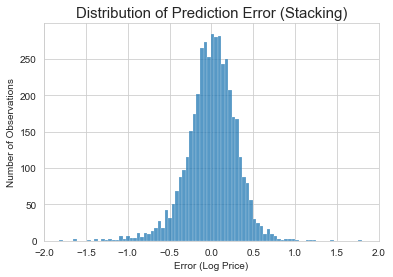

In [ ]:
sns.histplot(df_pred['deviation'])
plt.xlabel('Error (Log Price)')
plt.ylabel('Number of Observations')
plt.title('Distribution of Prediction Error (Stacking)', fontsize = 15)
plt.xlim(-2, 2)
plt.show()

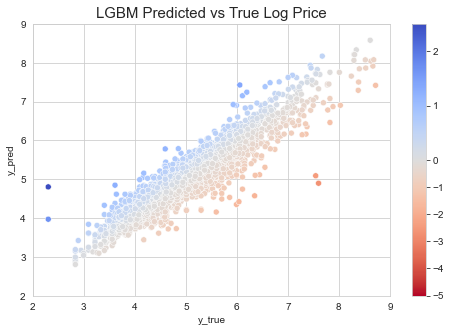

In [ ]:

lgbm_best.fit(X_train, y_train)
pred = lgbm_best.predict(X_test)
df_pred = pd.DataFrame.from_dict({'y_pred': pred, 'y_true': y_test})
df_pred['deviation'] = df_pred['y_pred'] - df_pred['y_true']

# Get/set params for the colour mapping
vcenter = 0
vmin, vmax = df_pred['deviation'].min(), df_pred['deviation'].max()
normalize = mcolors.TwoSlopeNorm(vcenter=vcenter, vmin=vmin, vmax=vmax)
colormap = cm.coolwarm_r

plt.figure(figsize = (8,5))
sns.scatterplot(x = 'y_true', y = 'y_pred', data = df_pred,  
                cmap=colormap, c=df_pred['deviation'], norm=normalize)

scalarmappaple = cm.ScalarMappable(norm=normalize, cmap=colormap)
scalarmappaple.set_array(df_pred['deviation'])
plt.colorbar(scalarmappaple)
plt.ylim(2,9)
plt.xlim(2,9)
plt.title('LGBM Predicted vs True Log Price', fontsize = 15)
plt.show()

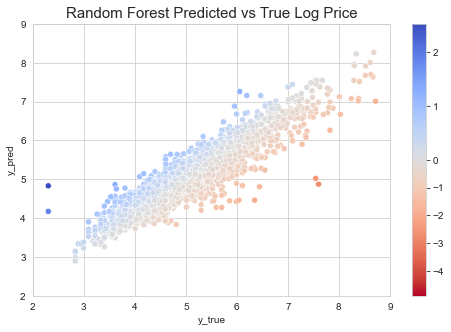

In [ ]:
rf_best.fit(X_train, y_train)
pred = rf_best.predict(X_test)
df_pred = pd.DataFrame.from_dict({'y_pred': pred, 'y_true': y_test})
df_pred['deviation'] = df_pred['y_pred'] - df_pred['y_true']

# Get/set params for the colour mapping
vcenter = 0
vmin, vmax = df_pred['deviation'].min(), df_pred['deviation'].max()
normalize = mcolors.TwoSlopeNorm(vcenter=vcenter, vmin=vmin, vmax=vmax)
colormap = cm.coolwarm_r

plt.figure(figsize = (8,5))
sns.scatterplot(x = 'y_true', y = 'y_pred', data = df_pred,  
                cmap=colormap, c=df_pred['deviation'], norm=normalize)

scalarmappaple = cm.ScalarMappable(norm=normalize, cmap=colormap)
scalarmappaple.set_array(df_pred['deviation'])
plt.colorbar(scalarmappaple)
plt.ylim(2,9)
plt.xlim(2,9)
plt.title('Random Forest Predicted vs True Log Price', fontsize = 15)
plt.show()

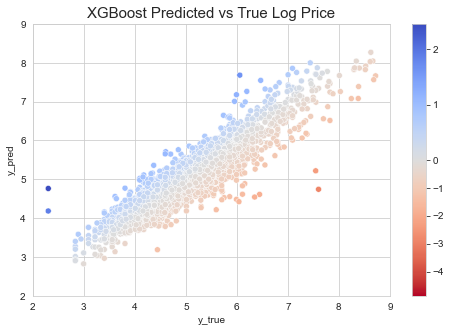

In [ ]:
xgb_best.fit(X_train, y_train)
pred = xgb_best.predict(X_test)
df_pred = pd.DataFrame.from_dict({'y_pred': pred, 'y_true': y_test})
df_pred['deviation'] = df_pred['y_pred'] - df_pred['y_true']

# Get/set params for the colour mapping
vcenter = 0
vmin, vmax = df_pred['deviation'].min(), df_pred['deviation'].max()
normalize = mcolors.TwoSlopeNorm(vcenter=vcenter, vmin=vmin, vmax=vmax)
colormap = cm.coolwarm_r

plt.figure(figsize = (8,5))
sns.scatterplot(x = 'y_true', y = 'y_pred', data = df_pred,  
                cmap=colormap, c=df_pred['deviation'], norm=normalize)

scalarmappaple = cm.ScalarMappable(norm=normalize, cmap=colormap)
scalarmappaple.set_array(df_pred['deviation'])
plt.colorbar(scalarmappaple)
plt.ylim(2,9)
plt.xlim(2,9)
plt.title('XGBoost Predicted vs True Log Price', fontsize = 15)
plt.show()